# Project Introduction

This project aims to built a model to predict a loan status upon information of the borrower.

# 1. Data Importing

In [1]:
import numpy as np
import pandas as pd
import os
import sqlalchemy as sqla
import sqlite3 as sql
from sqlite3 import Error
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
file_loc = os.getcwd()

In [3]:
file_loc

'C:\\Users\\Administrator\\1-STA208\\STA-208-project'

In [4]:
db1= sql.connect(file_loc+"\data1.db")
df1=pd.read_sql("SELECT * FROM loan",db1)
db2= sql.connect(file_loc+"\data2.db")
df2=pd.read_sql("SELECT * FROM loan",db2)
db3= sql.connect(file_loc+"\data3.db")
df3=pd.read_sql("SELECT * FROM loan",db3)
db4= sql.connect(file_loc+"\data4.db")
df4=pd.read_sql("SELECT * FROM loan",db4)
db5= sql.connect(file_loc+"\data5.db")
df5=pd.read_sql("SELECT * FROM loan",db5)
db6= sql.connect(file_loc+"\data6.db")
df6=pd.read_sql("SELECT * FROM loan",db6)
db7= sql.connect(file_loc+"\data7.db")
df7=pd.read_sql("SELECT * FROM loan",db7)
db8= sql.connect(file_loc+"\data8.db")
df8=pd.read_sql("SELECT * FROM loan",db8)
db9= sql.connect(file_loc+"\data9.db")
df9=pd.read_sql("SELECT * FROM loan",db9)
db10= sql.connect(file_loc+"\data10.db")
df10=pd.read_sql("SELECT * FROM loan",db10)
db11= sql.connect(file_loc+"\data11.db")
df11=pd.read_sql("SELECT * FROM loan",db11)
db12= sql.connect(file_loc+"\data12.db")
df12=pd.read_sql("SELECT * FROM loan",db12)

In [5]:
df = pd.DataFrame()
df = df.append(df1)
df = df.append(df2)
df = df.append(df3)
df = df.append(df4)
df = df.append(df5)
df = df.append(df6)
df = df.append(df7)
df = df.append(df8)
df = df.append(df9)
df = df.append(df10)
df = df.append(df11)
df = df.append(df12)
df.shape

(434407, 65)

In [6]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,...,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,17600,17600,17600,36 months,10.75%,574.12,B,B4,RENT,57109,...,6,0,1,95.1,1,0,88629,83563,2300,80329
1,12500,12500,12500,60 months,8.39%,255.8,B,B1,RENT,120000,...,9,0,1,100,0,0,80899,40673,48400,32499
2,10000,10000,10000,36 months,11.99%,332.1,C,C1,MORTGAGE,75000,...,9,0,2,100,0,1,71858,48844,0,60358
3,3000,3000,3000,36 months,7.39%,93.17,A,A4,RENT,80000,...,6,0,0,95,0,0,221908,25665,42200,30936
4,2000,2000,2000,36 months,6.49%,61.29,A,A2,RENT,90000,...,19,0,2,97.3,0,0,176338,68841,122100,48438


# 2. Data Processing

### 2.1 Prelimilary Data cleansing

Through the prelimilary data viewing and the dictionary of all variables (you are able to reach out it at [Data Dictionary](https://resources.lendingclub.com/LCDataDictionary.xlsx)), we do the data cleansing as the following:

1. Notice that the __grade__ and __subgrade__ variables are assessed directly from the interest rate, that is, the variable __int_rate__. Thus, mere __int_rate__ suffices to cover the information provided by them, and __grade__ and __subgrade__ can be removed from our list of variables. 

2. __zip_code__ is not appropriate to be deemed as a variable. ALso, the __addr_state__ includes the information.

3. __issue_d__, __earliest_cr_line__ and __last_credit_pull_d__ don't contain valuable information, we also drop them.

4. __collection_recovery_fee__ would definitely has a ratio relationship with __recoveries__ which should be dropped here.

5. Since __total_pymnt__ is the sum of __total_rec_prncp__, __total_rec_int__, and __total_rec_late_fee__. Meanwhile, __total_pymnt_inv__ is almost the same as __total_pymnt__, obviously we should drop both of them to avoid multicollinearity. 

6. Finally, as __funded_amnt__,__funded_amnt_inv__ and __out_prncp_inv__ are all duplicate X variables in the dataset, we drop them as well.

In [7]:
data = df.copy()

col_drop = ['grade','sub_grade','issue_d','earliest_cr_line','zip_code','collection_recovery_fee',
            'total_pymnt', 'total_pymnt_inv','last_credit_pull_d', 'funded_amnt','funded_amnt_inv','out_prncp_inv']
data = data.drop(col_drop, axis = 1)
data = data.reset_index(drop=True)
data.shape

(434407, 53)

### 2.2  Dummy variables creation

Among the __$53$__ variables we have now, some of them are quantitative and have only a few statuses. For these variables, we can establish dummy variables that take either 0 or 1. For quantitative variables that have more than two categories, we combine some of to create more synthesized categories.

1. Response variable: __loan_status__

   Because it has $7$ different categories, `Fully paid`, `Current`, `In Grace Period`, `Late(16-30 days)`, `Late(31-120 days)`, `Default`, `Charged Off`, we want to categorize them into two groups that result to a binary variable. 
   
   Since the first two categories are signs of a good status of loan, and the latter five indicate different extents of late payment, we denote __good status__ as `Fully paid` or `Current`, and __bad status__ as `In Grace Period`, `Late(16-30 days)`, `Late(31-120 days)`, `Default` or `Charged Off`.
   
   __loan_status__$=
    \left\{\begin{array}{cl} 
            1,& \text{good status}\\
            0,& \text{bad status}
        \end{array}\right.$

2. Predictor varible 1: __purpose__
    
    It also has multiple categories: `car, home-improvement, house, moving, major_purchase, renewable_enery, credit_card, debt_consolidation, small_business, medical, vacation and other`, which requires many dummy variables. 
    
    To make the situation simpler, except for __`medical`__, we classify `car, home_improvement, house, moving, major_purchase and renewable_enery` as __`property`__, `credit_card, debt_consolidation and small_business, vacation and other` as __`financial`__. Therefore, we get $3$ categories of purposes, which can be represented by $2$ dummy variables:

    __purpose1__$=
    \left\{\begin{array}{cl} 
            1,& \text{financial}\\
            0,& \text{medical} 
        \end{array}\right.$
        
    __purpose2__$=
    \left\{\begin{array}{cl} 
            1,&\text{property} \\
            0,&\text{medical}  
        \end{array}\right.$

3. Predictor varible 2: __addr_state__

    It records the state address of the borrower. Considering the data is collected from Lending Club, which locates in San Francisco, CA, we want to know whether it makes a difference if the loan request is from an instate borrower or not. In this case, we only have to make a distinction between a California loaner and a non California borrower.

    __addr_state__$=
    \left\{\begin{array}{cl} 
            1,&\text{California} \\
            0,&\text{other states}  
        \end{array}\right.$

4. Predictor varible 3: __verification_status__

    Similarly, in verification_status, we combine verified and source verified as verified:

    __verification_status__$=
    \left\{\begin{array}{cl} 
            1,& \text{verified}\\
            0, & \text{not verified}
        \end{array}\right.$
 
5. The other 4 more qualitative variables, which are coded as below:

    __term__$=
    \left\{\begin{array}{cl} 
            1,&\text{36 months} \\
            0,&\text{60 others}  
        \end{array}\right.$
 
    __home_ownership1__$=
    \left\{\begin{array}{cl} 
            1,& \text{rent}\\
            0,& \text{any}  
        \end{array}\right.$ 
    __home_ownership2__$=
    \left\{\begin{array}{cl} 
            1,& \text{own}\\
            0,& \text{any}
        \end{array}\right.$ 
    __home_ownership3__$=
    \left\{\begin{array}{cl} 
            1,& \text{mortage}\\
            0,& \text{any} 
        \end{array}\right.$

    __initial_list_status__$=
    \left\{\begin{array}{cl} 
            1,& \text{whole}\\
            0,& \text{fraction}
        \end{array}\right.$

    __application_type__$=
    \left\{\begin{array}{cl} 
            1,& \text{Individual}\\
            0,& \text{Joint App}
        \end{array}\right.$

In [8]:
y_temp = data['loan_status']

In [9]:
# recode loan_status
y = y_temp.copy()
for i in range(len(y)):
    if (y_temp[i] == 'Fully Paid') or (y_temp[i] == 'Current'):
        y[i] = 'good'
    else:
        y[i] = 'bad'

In [10]:
y.head()

0    good
1    good
2    good
3    good
4    good
Name: loan_status, dtype: object

In [11]:
purpose_temp = data['purpose']

In [12]:
#recode purposes
purpose = purpose_temp.copy()
for i in range(len(purpose)):
    if (purpose_temp[i] == 'credit_card') or ( purpose_temp[i] == 'debt_consolidation') or (purpose_temp[i] == 'small_business') or (purpose_temp[i] == 'vacation') or (purpose_temp[i] == 'other'):
        purpose[i] = 'financial'
    elif purpose_temp[i] == 'medical':
        purpose[i] == 'medical'
    else:
        purpose[i] = 'property'

In [13]:
purpose.head()

0    financial
1    financial
2    financial
3    financial
4    financial
Name: purpose, dtype: object

In [14]:
addr_state_temp = data['addr_state']

In [15]:
#recode addr_state
addr_state = addr_state_temp.copy()
for i in range(len(y)):
    if addr_state_temp[i] == 'CA':
        addr_state[i] = 'CA'
    else:
        addr_state[i] = 'other'

In [16]:
addr_state.head()

0    other
1    other
2    other
3    other
4    other
Name: addr_state, dtype: object

In [17]:
verification_status_temp = data['verification_status']

In [18]:
#recode addr_state
verification_status = verification_status_temp.copy()
for i in range(len(y)):
    if verification_status_temp[i] == 'Not Verified':
        verification_status[i] = 'not verified'
    else:
        verification_status[i] = 'verified'

In [19]:
verification_status.head()

0        verified
1    not verified
2    not verified
3    not verified
4    not verified
Name: verification_status, dtype: object

In [20]:
#Create dummy variables
dummy1 = pd.get_dummies(y)
dummy2 = pd.get_dummies(purpose)
dummy3 = pd.get_dummies(addr_state)
dummy4 = pd.get_dummies(data['term'])
dummy5 = pd.get_dummies(data['home_ownership'])
dummy6 = pd.get_dummies(verification_status)
dummy7 = pd.get_dummies(data['initial_list_status'])
dummy8 = pd.get_dummies(data['application_type'])

In [21]:
#Insert dummy variables into dataset
data['loan_status'] = dummy1['good']
data['addr_state'] = dummy3['CA']
data['term'] = dummy4[' 36 months']
data['verification_status'] = dummy6['verified']
data['initial_list_status'] = dummy7['w']
data['application_type'] = dummy8['Individual']

data = data.drop(['purpose','home_ownership'], axis = 1)
data = pd.concat([data, dummy2.iloc[:,[0,2]],dummy5.iloc[:,1:4]],axis = 1)

# convert all data as float
data['int_rate'] = [x[:-1] for x in data['int_rate']]
data = data.astype(float)
data['int_rate'] = data['int_rate']/100

data.head()

,loan_amnt,term,int_rate,installment,annual_inc,verification_status,loan_status,addr_state,delinq_2yrs,open_acc,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,financial,property,MORTGAGE,OWN,RENT
0,17600.0,1.0,0.1075,574.12,57109.0,1.0,1.0,0.0,0.0,6.0,...,0.0,88629.0,83563.0,2300.0,80329.0,1.0,0.0,0.0,0.0,1.0
1,12500.0,0.0,0.0839,255.80,120000.0,0.0,1.0,0.0,0.0,9.0,...,0.0,80899.0,40673.0,48400.0,32499.0,1.0,0.0,0.0,0.0,1.0
2,10000.0,1.0,0.1199,332.10,75000.0,0.0,1.0,0.0,0.0,9.0,...,1.0,71858.0,48844.0,0.0,60358.0,1.0,0.0,1.0,0.0,0.0
3,3000.0,1.0,0.0739,93.17,80000.0,0.0,1.0,0.0,1.0,6.0,...,0.0,221908.0,25665.0,42200.0,30936.0,1.0,0.0,0.0,0.0,1.0
4,2000.0,1.0,0.0649,61.29,90000.0,0.0,1.0,0.0,0.0,19.0,...,0.0,176338.0,68841.0,122100.0,48438.0,1.0,0.0,0.0,0.0,1.0


In [22]:
# store the categorical variable indexes
data_category = ['loan_status','verification_status','addr_state', 'term', 'initial_list_status',
                 'application_type','financial','property','MORTGAGE','OWN','RENT']

### 2.3 Variable Selection (Group Lasso)

As we have two sets of group dummy variables, __Group Lasso__ has been taken into consideration since __the simple Lasso__ seems to unsuitable here.

In [28]:
from pyglmnet import GLM
from  sklearn.preprocessing  import scale

data_lasso = data.copy()

# Scale the numerical variables
data_lasso[data.columns[~data_lasso.columns.isin(data_category)]]=scale(data_lasso[data.columns[~data_lasso.columns.isin(data_category)]])

In [29]:
X = data_lasso[data_lasso.columns.difference(['loan_status'])].values
y = data_lasso.loc[:, 'loan_status'].values
X=X.astype(float)

In [27]:
group_idxs = np.arange(len(data_lasso.columns)-1)+1
group_idxs[-3:] = group_idxs[-4]
group_idxs[-5:-3] = group_idxs[-5]
group_idxs = group_idxs.astype('int64')
group_idxs

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       51, 52, 52, 52], dtype=int64)

#### ----$\lambda$ Selection----

Since we've tried lots of different $\lambda$, during which the __pseudo-__$ R^2$ shows to keep decreasing from $\lambda = 1$. Finally we bulid the Group Lasso through trying 250 different $\lambda$ ranging from $0.01$ to $1$ as the following:

In [65]:
#set up the group lasso GLM model
trial_lambda=np.logspace(np.log(100), np.log(.01), 500, base=np.exp(1))[250:]

gl_glm = GLM(distr="binomial",
             tol=1e-2,
             group=group_idxs,
             score_metric="pseudo_R2",
             #solver = 'cdfast',
             alpha=1,
             reg_lambda=trial_lambda)

In [66]:
gl_glm.fit(X, y)

<
Distribution | binomial
alpha | 1.00
max_iter | 1000.00
lambda: 0.99 to 0.01
>

In [67]:
# get the pseudo-R^2
R_2 = gl_glm.score(X, y)

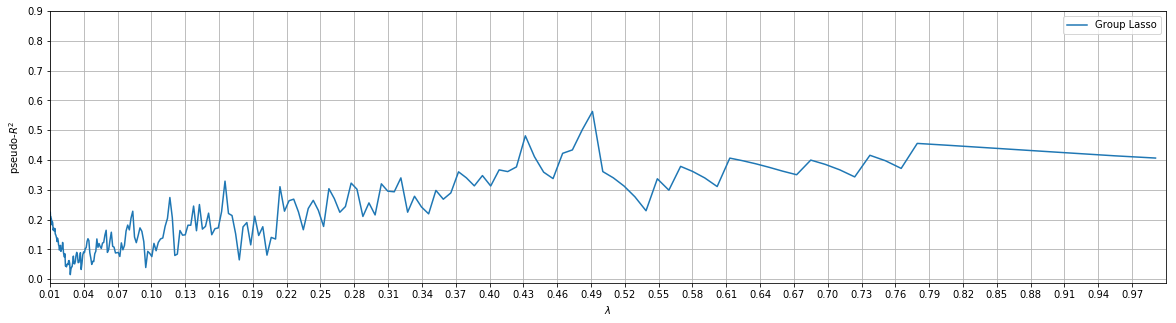

In [71]:
plt.figure(figsize=(20,5))
plt.plot(gl_glm.reg_lambda, R_2, label = 'Group Lasso')
plt.xlabel('$\lambda$')
plt.ylabel('pseudo-$R^2$')
#plt.ylim([-0.1, 0.7])
plt.xlim([.01,1])

plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
ax = plt.gca()

ax.set_xticks(np.arange(0.01, 1,.03))
#ax.set_xticks(np.arange(0, 1, .05))
ax.set_yticks(np.arange(0, 1., 0.1))
plt.grid()

plt.legend()
plt.show()

In [85]:
sum(reg_lambda>.485)

39

In [75]:
# upon above graph, we are able to get the best lambda and best beta which are the following:
print('Best lambda is',reg_lambda[38])
best_beta_1 = gl_glm.fit_[38]['beta']
best_beta_1[-5:]

Best lambda is 0.49134072862963607


array([[ 0.36858478],
       [-0.32241935],
       [ 0.23573884],
       [ 0.01323486],
       [ 0.01044898]])

Also, through trying a big range of $\lambda$ from $1$ to $10^{10}$, we are still not able to zero out any X variables. Finally, we decide to set a reasonable threshold to realize the property of __Group Lasso__.

Upon the above output(the last five coefficients of the two sets of group dummy variables), $0.05$ becomes the ideal choice, and it successfully selects out $18$ predictor variables.

In [79]:
sum(abs(best_beta_1)>.05)

array([18])

In [80]:
select_X = abs(best_beta_1)>.05
# below are the selected x variables
selected_X = data.columns.drop('loan_status')[select_X.T[0]]
data[selected_X].head()

,loan_amnt,term,int_rate,annual_inc,out_prncp,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,num_bc_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_op_past_12m,total_bc_limit,finantial,property,MORTGAGE
0,17600.0,1.0,0.1075,57109.0,0.00,17600.00,1105.74,0.0,0.0,14521.94,9.0,4.0,2.0,1.0,2300.0,1.0,0.0,0.0
1,12500.0,0.0,0.0839,120000.0,7716.54,4783.46,1855.69,0.0,0.0,255.80,6.0,6.0,4.0,1.0,48400.0,1.0,0.0,0.0
2,10000.0,1.0,0.1199,75000.0,3145.38,6854.62,1766.66,0.0,0.0,332.10,7.0,5.0,3.0,2.0,0.0,1.0,0.0,1.0
3,3000.0,1.0,0.0739,80000.0,588.27,2411.73,301.62,0.0,0.0,93.17,8.0,4.0,3.0,0.0,42200.0,1.0,0.0,0.0
4,2000.0,1.0,0.0649,90000.0,0.00,2000.00,108.98,0.0,0.0,1497.52,16.0,17.0,7.0,2.0,122100.0,1.0,0.0,0.0


In [81]:
selected_X

Index(['loan_amnt', 'term', 'int_rate', 'annual_inc', 'out_prncp',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'last_pymnt_amnt', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0',
       'num_tl_op_past_12m', 'total_bc_limit', 'finantial', 'property',
       'MORTGAGE'],
      dtype='object')

#### Analysis of selected Variables upon Group Lasso

The following $18$ selected variables are all reasonable to be high impact factors for the __loan status__.


1. __loan_amnt__ (the list amount of the loan applied by the borrowers), __term__ (The number of payments on the loan. 36months/60months), __int_rate__ (interest rate on the loan), __annual_inc__ (The self-reported annual income provided by the borrower during registration) would definitely be the critical part that determine and demonstrate the loan repayment pressure and financial capacity.

2. __out_prncp__ (Remaining outstanding principal for total amount funded), __total_rec_prncp__ (Principal received to date), __total_rec_int__ (Interest received to date), __total_rec_late_fee__ (Late fees received to date), __recoveries__ (post charge off gross recovery) and __last_pymnt_amnt__ (Last total payment amount received) are regarded as the record for this loan repayment status, which can be used to track and predict the future repayment capacity for the borrower.

3. __num_bc_tl__ (Number of bankcard accounts), __num_op_rev_tl__ (Number of open revolving accounts), __num_rev_tl_bal_gt_0__ (Number of revolving trades with balance >0), __num_tl_op_past_12m__ (Number of accounts opened in past 12 months), __total_bc_limit__ (Total bankcard high credit/credit limit) represents the borrower's credit and consumption status.

4. *__Purpose__ (finantial, property, medical): This group of dummy variables have all been covered under the 0.05 threshold and it is reasonable to be taken into consideration here.

5. __home_ownership__ (MORTGAGE): The coefficients of 'Rent' and 'OWN' status is much smaller compared to that of 'MORGAGE', which makes sense here since for borrowers whose home is under the morgage status, definitely have a heavier pressure which would be an important factor to impact the final loan status.

### 2.4 Data Description

#### 2.4.1 Numerical Variables

After we selected significant predictor variables, we start our fundemental data analysis. First we strat with numerical predictor variables.

In [23]:
# set nex data with numerical variables
selected_X = ['loan_amnt', 'term', 'int_rate', 'annual_inc', 'out_prncp',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'last_pymnt_amnt', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0',
       'num_tl_op_past_12m', 'total_bc_limit', 'financial', 'property',
       'MORTGAGE']

numerical = list(set(selected_X) - set(data_category))
newdata_numerical = data[numerical]
newdata_numerical.head()

,out_prncp,int_rate,num_tl_op_past_12m,last_pymnt_amnt,loan_amnt,total_rec_prncp,num_bc_tl,recoveries,total_bc_limit,total_rec_late_fee,total_rec_int,num_rev_tl_bal_gt_0,annual_inc,num_op_rev_tl
0,0.00,0.1075,1.0,14521.94,17600.0,17600.00,9.0,0.0,2300.0,0.0,1105.74,2.0,57109.0,4.0
1,7716.54,0.0839,1.0,255.80,12500.0,4783.46,6.0,0.0,48400.0,0.0,1855.69,4.0,120000.0,6.0
2,3145.38,0.1199,2.0,332.10,10000.0,6854.62,7.0,0.0,0.0,0.0,1766.66,3.0,75000.0,5.0
3,588.27,0.0739,0.0,93.17,3000.0,2411.73,8.0,0.0,42200.0,0.0,301.62,3.0,80000.0,4.0
4,0.00,0.0649,2.0,1497.52,2000.0,2000.00,16.0,0.0,122100.0,0.0,108.98,7.0,90000.0,17.0


In [24]:
newdata_numerical.shape

(434407, 14)

In [25]:
newdata_numerical.columns

Index(['out_prncp', 'int_rate', 'num_tl_op_past_12m', 'last_pymnt_amnt',
       'loan_amnt', 'total_rec_prncp', 'num_bc_tl', 'recoveries',
       'total_bc_limit', 'total_rec_late_fee', 'total_rec_int',
       'num_rev_tl_bal_gt_0', 'annual_inc', 'num_op_rev_tl'],
      dtype='object')

In [26]:
newdata_numerical.describe()

,out_prncp,int_rate,num_tl_op_past_12m,last_pymnt_amnt,loan_amnt,total_rec_prncp,num_bc_tl,recoveries,total_bc_limit,total_rec_late_fee,total_rec_int,num_rev_tl_bal_gt_0,annual_inc,num_op_rev_tl
count,434407.000000,434407.000000,434407.000000,434407.000000,434407.000000,434407.000000,434407.000000,434407.000000,4.344070e+05,4.344070e+05,434407.000000,434407.000000,4.344070e+05,434407.000000
mean,4968.585217,0.130421,2.224727,3306.869072,14734.039046,8460.913491,7.629256,92.375649,2.234170e+04,1.400073e+00,2242.643061,5.650565,7.949827e+04,8.315794
std,6288.505209,0.049308,1.935701,6185.253923,8991.621474,7226.895431,4.662369,556.510933,2.222200e+04,1.062623e+01,2115.219808,3.343577,7.726551e+04,4.753147
min,0.000000,0.053200,0.000000,0.000000,1000.000000,0.000000,0.000000,0.000000,0.000000e+00,-3.900000e-09,0.000000,0.000000,0.000000e+00,0.000000
25%,0.000000,0.094900,1.000000,293.670000,8000.000000,3448.560000,4.000000,0.000000,8.000000e+03,0.000000e+00,781.530000,3.000000,4.800000e+04,5.000000
50%,2649.590000,0.119900,2.000000,527.280000,12400.000000,6044.780000,7.000000,0.000000,1.570000e+04,0.000000e+00,1562.600000,5.000000,6.700000e+04,7.000000
75%,8051.770000,0.155900,3.000000,2696.325000,20000.000000,11054.470000,10.000000,0.000000,2.900000e+04,0.000000e+00,3018.305000,7.000000,9.500000e+04,11.000000
max,35331.770000,0.309900,32.000000,42148.530000,40000.000000,40000.000000,79.000000,37153.460000,1.105500e+06,1.188830e+03,19380.530000,59.000000,9.573072e+06,91.000000


We want to explore relationship between response variable and predictor variables and relationship between predictor variables. So we decide to compute correlation matrix. Previously when we use data to fit model, we found that it was faster when we used scaled data. Therefore here we also use scaled data to compute correlation matrix.

In [30]:
# set nex data (sca) with numerical variables
newdata_numerical_scale = data_lasso[numerical]

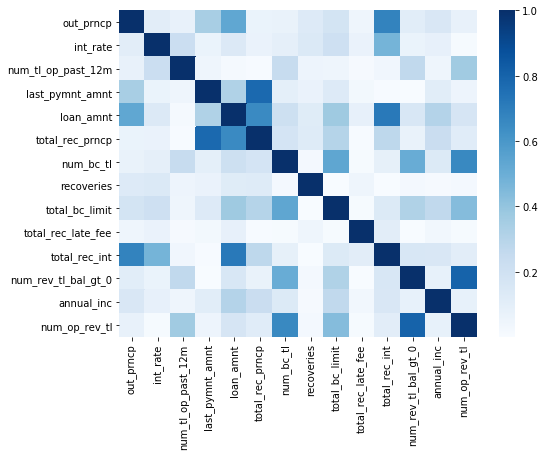

In [31]:
# draw correlation matrix and heatmap
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6)) 
corr = newdata_numerical_scale.corr()
sns.heatmap(abs(corr),cmap="Blues",ax=ax)

In [32]:
# show coefficients
corr

,out_prncp,int_rate,num_tl_op_past_12m,last_pymnt_amnt,loan_amnt,total_rec_prncp,num_bc_tl,recoveries,total_bc_limit,total_rec_late_fee,total_rec_int,num_rev_tl_bal_gt_0,annual_inc,num_op_rev_tl
out_prncp,1.000000,0.109354,-0.076279,-0.346314,0.531941,-0.065702,0.074495,-0.131151,0.183874,0.045709,0.682768,0.111197,0.156549,0.077036
int_rate,0.109354,1.000000,0.227151,0.065918,0.138625,-0.069325,-0.094410,0.143068,-0.210946,0.071627,0.474430,0.066796,-0.086169,-0.011884
num_tl_op_past_12m,-0.076279,0.227151,1.000000,0.049750,-0.019302,-0.008769,0.246000,0.055602,0.051642,0.015495,0.037647,0.266691,0.051651,0.365220
last_pymnt_amnt,-0.346314,0.065918,0.049750,1.000000,0.320882,0.778589,0.097827,-0.071597,0.132947,-0.025014,0.006610,0.004662,0.110693,0.053430
loan_amnt,0.531941,0.138625,-0.019302,0.320882,1.000000,0.653621,0.214271,0.120202,0.373556,0.084394,0.719434,0.161313,0.307442,0.170019
total_rec_prncp,-0.065702,-0.069325,-0.008769,0.778589,0.653621,1.000000,0.180400,-0.128802,0.303056,0.007546,0.276272,0.073689,0.232683,0.116841
num_bc_tl,0.074495,-0.094410,0.246000,0.097827,0.214271,0.180400,1.000000,0.021036,0.537191,-0.010164,0.091133,0.511279,0.135779,0.657704
recoveries,-0.131151,0.143068,0.055602,-0.071597,0.120202,-0.128802,0.021036,1.000000,0.001439,0.048622,0.004489,0.024400,0.016917,0.023644
total_bc_limit,0.183874,-0.210946,0.051642,0.132947,0.373556,0.303056,0.537191,0.001439,1.000000,-0.009938,0.137288,0.320432,0.268748,0.437927
total_rec_late_fee,0.045709,0.071627,0.015495,-0.025014,0.084394,0.007546,-0.010164,0.048622,-0.009938,1.000000,0.108788,0.002311,0.033394,-0.010827


From the above correlation matrix and coefficients we can see that there seems no severe multicollinearity, which means our model fits data well. We also notice that our model selects many variables concerning accounts, such as num_bc_tl, num_op_rev_tl and num_tl_op_past_12m. We want to explore the relationship between these variables and we also draw heatmap.

In [33]:
account = ['num_bc_tl','num_op_rev_tl','num_tl_op_past_12m']
newdata_numerical_account = data_lasso[account]
newdata_numerical_account.head()

,num_bc_tl,num_op_rev_tl,num_tl_op_past_12m
0,0.294002,-0.907988,-0.632705
1,-0.349448,-0.487213,-0.632705
2,-0.134965,-0.697600,-0.116096
3,0.079519,-0.907988,-1.149315
4,1.795386,1.827046,-0.116096


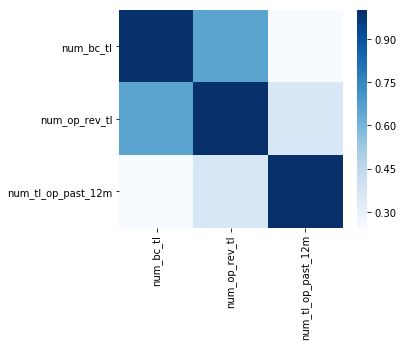

In [34]:
fig, ax = plt.subplots(figsize=(5,4)) 
corr = newdata_numerical_account.corr()
sns.heatmap(corr,cmap="Blues",ax=ax)

In [35]:
# show coefficients
corr

,num_bc_tl,num_op_rev_tl,num_tl_op_past_12m
num_bc_tl,1.000000,0.657704,0.24600
num_op_rev_tl,0.657704,1.000000,0.36522
num_tl_op_past_12m,0.246000,0.365220,1.00000


By exploring relationship between variables concerning accounts, we find that they are not highly correlated.  
Next we want to explore relationship between response variable and some predictor variables we are interested in.  
We start with loan status and loan amount.

In [36]:
numerical = ['loan_status'] + numerical
newdata_numerical = data[numerical]

In [37]:
newdata_numerical['loan_amnt'].groupby(newdata_numerical['loan_status']).count()

loan_status
0.0     57600
1.0    376807
Name: loan_amnt, dtype: int64

From the count we can see that most of borrowers are in good loan status. However, there is still a small portion that 
borrowers pay money back late.

In [38]:
newdata_numerical['loan_amnt'].groupby(newdata_numerical['loan_status']).mean()

loan_status
0.0    15651.879340
1.0    14593.734856
Name: loan_amnt, dtype: float64

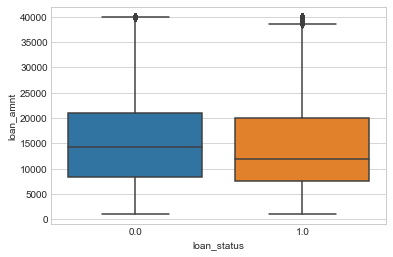

In [39]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="loan_status", y="loan_amnt", data=newdata_numerical)

From the boxplot above we can see there seems no significant difference in loan amount between two loan status, this result is consistent with the  correlation coefficient between loan amount and two loan status, which is -0.039910.  
Then we come to loan status and interest rate.

In [40]:
newdata_numerical['int_rate'].groupby(newdata_numerical['loan_status']).mean()

loan_status
0.0    0.158339
1.0    0.126153
Name: int_rate, dtype: float64

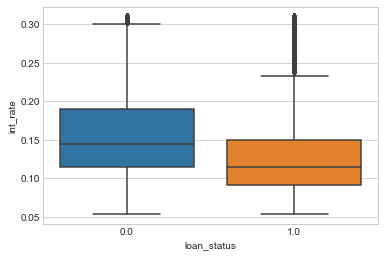

In [41]:
sns.set_style("whitegrid")
ax = sns.boxplot(x="loan_status", y="int_rate", data=newdata_numerical)

It is obvious that average interest rate of bad loan status in much higner than that in goood status. This result also makes sense because borrowers with high loan credit grade can borrow money with low interest rate and they are more likely to pay money back in time compared with those with low loan credit grade.
Last but not least, we are interested in relationship between loan status and recoveries.

#### 2.4.1 Categorical Variables

Then we focus on categorical variables and we want to draw barplot for pairs of each categorical variable and response variable.

In [43]:
# set nex data with categorical variables
categorical = list(set(selected_X) - set(numerical))
categorical = ['loan_status'] + categorical
newdata_categorical = data[categorical]
newdata_categorical.head()

,loan_status,term,financial,MORTGAGE,property
0,1.0,1.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,0.0,0.0
4,1.0,1.0,1.0,0.0,0.0


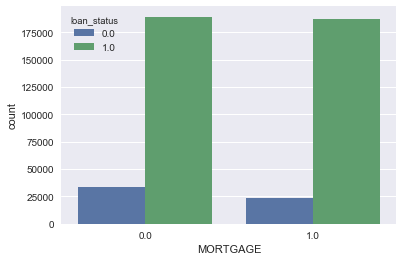

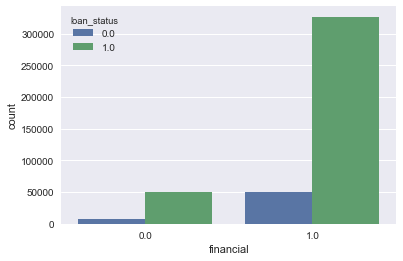

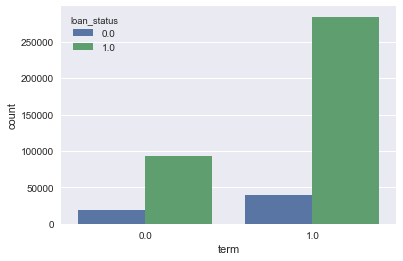

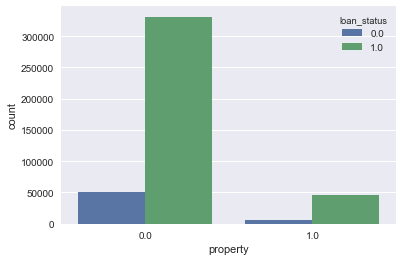

In [44]:
# draw barplot
sns.set(style="darkgrid")
buckets = ['MORTGAGE','financial','term', 'property']
for i in buckets:
    sns.countplot(x = i, hue = "loan_status", data = newdata_categorical)
    plt.show()

From the above 4 barplot, we can conclude that whatever the value of each dummy variable, number of loan in good status is much more than that in bad status, indicating most borrowers can pay money back in time, which is also consistent with what we find in last part. However, there is significant difference between these dummy variables.    
For __home_ownership__, we can see nearly half of borrowers are in __mortgage__ status and most of these borrowers are in good loan status.  
For __purpose__, we can see most borrowers borrow money for __financial__  use and larger proportion of these borrowers are in good loan status.  
For __term__, we can see most borrowers are in a 36-month loan period and larger proportion of these borrowers are in good loan status.  
For __purpose__, we can see few borrowers borrow money for __property__ and smaller proportion of these borrowers are in good loan status.